# Aufgabe 3: Aufgabe 3: Cross Validation und Grid Search

In dieser Aufgabe geht es um Hyperparameter-Optimierung mittels Grid-Search (deutsch: Gittersuche). Dabei handelt es sich um eine Brute-Force-Suche, die auf einen angegebenen Teil des Hyperparameterraums angewandt wird. Sie wird dabei von einer Performance-Metrik geleitet.

Die Gittersuche soll in diesem Notebook auf zwei verschiedene Klassifikationsaufgaben angewandt werden:

- Iris Flower Dataset
- evtl breast cancer?

Anschließend soll für beide Aufgaben jeweils eine Kurve mit der Suchzeit in Abhängigkeit von der Anzahl an CPU- Kernen geplottet werden. Außerdem soll die Zielmetrik in Abhängigkeit von einem ausgewählten Hyperparameter geplottet werden.

## Importiere Bibliotheken

In [16]:
# Import Libraries
import time
import multiprocessing

import pandas as pd

from sklearn import svm
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn import datasets

## Iris Flower Dataset

In [3]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
iris = pd.read_csv(url, names=names)

In [14]:
iris.shape

(150, 5)

Iteriere durch die Anzahl der vorhandenen Prozessorkerne und starte jeweils ein GridSearch. Miss jeweils die notwendige Zeit für das Fitting und speicher Ergebnis in eine Liste.

In [5]:
# Split-out validation dataset
array = iris.values
X = array[:,0:4]
Y = array[:,4]
test_size = 0.20
seed = 7
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

In [9]:
def grid_search_with_cores(classifier, parameters, X_train, y_train, core_range=None):
    
    if core_range is None:
        core_range = list(range(1, multiprocessing.cpu_count()+1))
        
    results = pd.DataFrame(columns=['n_cores', 'times'])

    for n in core_range:
        # Instanciate Grid Search
        grid_search = GridSearchCV(classifier, parameters, n_jobs=n)

        # Start time measurement
        start = time.time()

        # Modell trainieren
        grid_search.fit(X_train, y_train)

        # End time measurement
        end = time.time()

        # Append results
        results = results.append(pd.DataFrame.from_dict({'n_cores': [n], 'times': [end - start]}))

        # pd.DataFrame(data=grid_search.cv_results_)

    # Ergebnissliste in DataFrame umwandeln
    return results

In [10]:
# Hyper-Parameter Space
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

# SVM als Klassifikator
svc = svm.SVC()

times_iris = grid_search_with_cores(svc, parameters, X_train, y_train, core_range=None)

In [11]:
def plot_times(results):
    plot = results.plot(x='n_cores', y='times', legend=False)
    plot.set(xlabel="#Cores", ylabel="Time in seconds")

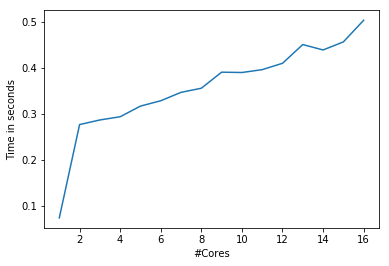

In [13]:
plot_times(times_iris)

## Breast Cancer

In [17]:
bc = datasets.load_breast_cancer()
print(bc.data.shape)
print(bc.target.shape)

(569, 30)
(569,)


Iteriere durch die Anzahl der vorhandenen Prozessorkerne und starte jeweils ein GridSearch. Miss jeweils die notwendige Zeit für das Fitting und speicher Ergebnis in eine Liste.

In [19]:
# Hyper-Parameter Space
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

# SVM als Klassifikator
svc = svm.SVC()

times_bc = grid_search_with_cores(svc, parameters, X_train=bc.data, y_train=bc.target, core_range=None)

In [ ]:
df

Plotte die benötigte Zeit in Abhängigkeit zur Anzahl der Kerne

In [ ]:
plot = df.plot(x='n_cores', y='times', legend=False)
plot.set(xlabel="#Cores", ylabel="Time in seconds")

Plotte die Ergebnisse der letzten Iteration, also mit allen Kernels

In [ ]:
results